## Making sense of your imaging data

### PortuguesLab Hackathon

#### Making sense of your imaging data

---


1. (very) Brief introduction to xarray
2.  ROI response reliability
3. Clustering your responses

Let's start with some basic imports and the sample dataset.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import flammkuchen as fl
import matplotlib.pyplot as plt 

In [3]:
#Import data
dataset = fl.load('/home/otprat/Desktop/hackathon2021/sample_dataset')

#Some hardcoded necessary variables that I was too lazy to add in the dictionary
n_blocks = 30
dt = 0.25 

dataset.keys()

dict_keys(['stim', 'traces'])

In [4]:
traces = dataset['traces']
stim_arr = dataset['stim']

In [5]:
traces.shape

(1300, 30, 319)

<IPython.core.display.Javascript object>


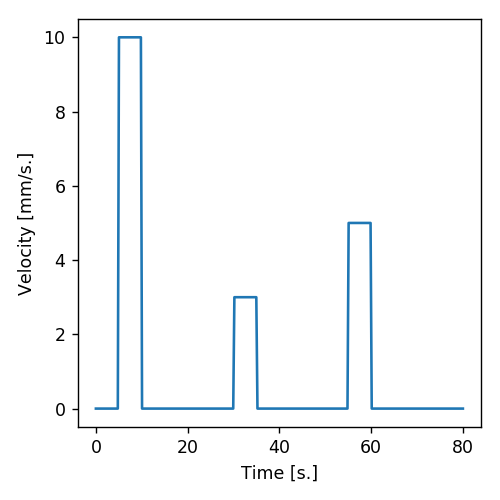

In [6]:
plt.figure(figsize=(4,4))
plt.plot(stim_arr[0, :], stim_arr[1, :])
plt.xlabel('Time [s.]')
plt.ylabel('Velocity [mm/s.]')
plt.tight_layout()

### 1. (very) Brief introduction to xarray

[Xarray](http://xarray.pydata.org/en/stable/index.html) is a Python package tailored to those working with multidimensional arrays. 

Built on top of NumPy, it introduces labels in the form of dimensions and coordinates. Also includes a large library of domain-agnostic functions for analytics and visualization with these data structures.

Install with:

`$ pip install xarray`

or

`$ conda install -c conda-forge xarray dask netCDF4 bottleneck`


In [7]:
import xarray as xr

When creating an `DataArray` object, besides the data it will contain, we will also need to specify the dimensions and coordinates of such array.

In [8]:
#Creating an xarray object with our data
traces_xr = xr.DataArray(
    data=traces,                               #Adding the data
    dims=['roi', 'block', 't'],                #Defining name of the dimensions
    coords={                                   #Defining values at which each dimension wase valuated
        'roi':np.arange(traces.shape[0]), 
        'block':np.arange(n_blocks),
        't':np.arange(traces.shape[2])*dt
        }
    )

In [9]:
traces_xr.coords

Coordinates:
  * roi      (roi) int64 0 1 2 3 4 5 6 7 ... 1293 1294 1295 1296 1297 1298 1299
  * block    (block) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * t        (t) float64 0.0 0.25 0.5 0.75 1.0 ... 78.5 78.75 79.0 79.25 79.5

Similarly as with `pandas`, we can index data within a `DataArray` both positionally and by its labels:

In [10]:
resp_sample = traces_xr[100, 15, :10] #Index-based indexing
resp_sample.shape

(10,)

In [11]:
resp_sample = traces_xr.loc[100, 15, :10] #Label-based indexing
resp_sample.shape

(41,)

As `xarray` is built on top of `numpy` arrays, most of the basic functions will also work on our data arrays.

In [12]:
mean_resps = np.nanmean(traces_xr, 1)
mean_resps.shape

(1300, 319)

For other packages that may not support such `xarray` objects, data can always be easily retrieved in a `numpy` format.

In [13]:
type(traces_xr.values)

numpy.ndarray

### 2. ROI response reliability

One may expect that imaged ROIs responding to the specific shown stimulus, will do so in a consistent manner across repetitions. Therefore, we could try to assess the reliability of our responses by measuring how similar the trace of a given neuron is across stimulation blocks.

Keep in mind that such an approach might get rid of ROIs that reliably respond upon bouts (for example), but that may not be occuring at the same moments during the experimental protocol. It might, instead, be a good approach to identify sensory ROIs. So be aware of what you are looking for, and notice that an ROI being unreliable, does not (always) mean it's useless.

To do so, we will use a function from `bouter` that takes care exactly of that:

In [39]:
from bouter.utilities import reliability

In [40]:
help(reliability)

Help on function reliability in module bouter.utilities:

reliability(data_block)
    Function to calculate reliability of cell responses.
    Reliability is defined as the average of the across-trials correlation.
    This measure seems to generally converge after a number of 7-8 repetitions, so it
    is advisable to have such a repetition number to use it.
    :param data_block: block of cell responses (t x n_trials x n_cells)
    :return:



In [41]:
# Calculate cross correlation between traces and set a threshold
reliability_arr = reliability(np.swapaxes(traces_xr, 0, 2).values)

Next, we need to decide what do we consider a reliable ROI.

Here, we will use the [Otsu's method](https://www.youtube.com/watch?v=jUUkMaNuHP8&ab_channel=JianWeiTay) for automatically thresholding our reliabilities.

In [42]:
#Import filtering method
from skimage.filters import threshold_otsu

#Apply to reliability histogram
rel_thresh = threshold_otsu(reliability_arr)
print('Reliability threshold set at {}'.format(rel_thresh))

Reliability threshold set at 0.4878493441778554


<IPython.core.display.Javascript object>


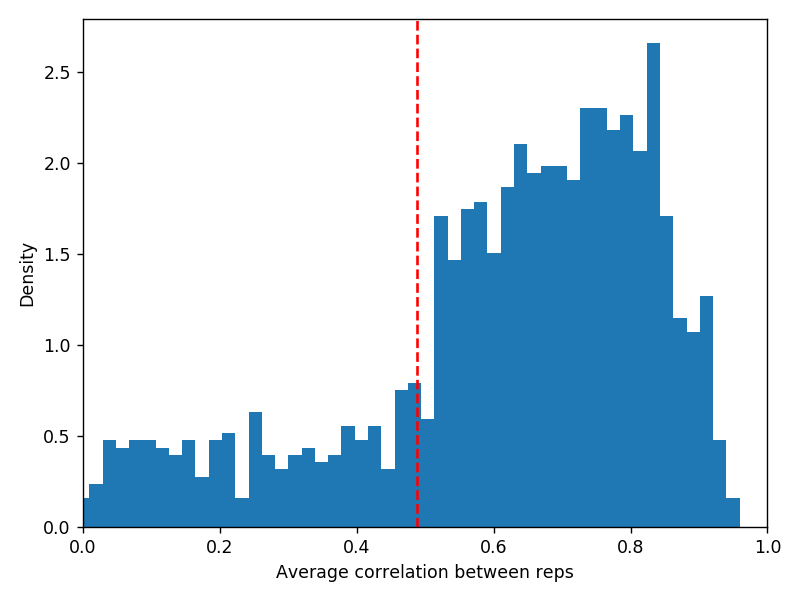

In [43]:
#Visualize
plt.figure()
plt.hist(reliability_arr, bins=50, density=True);
plt.axvline(rel_thresh, c='red', ls='--')

plt.xlim([0,1])
plt.xlabel('Average correlation between reps')
plt.ylabel('Density')
plt.tight_layout()

In [44]:
#Filter cropped traces 
filtered_traces_xr = traces_xr[reliability_arr >= rel_thresh]

But Otsu's Method is only one of many options...

In [45]:
from inspect import getmembers, isfunction
from skimage import filters

thresh_methods = [func for func in getmembers(filters, isfunction) if 'threshold_' in str(func) 
                  and all(s not in str(func) for s in ['local', 'sauvola', 'niblack', 'multiotsu'])]

thr_list = []

for method in thresh_methods:
    thr_list.append(method[1](reliability_arr))

<IPython.core.display.Javascript object>


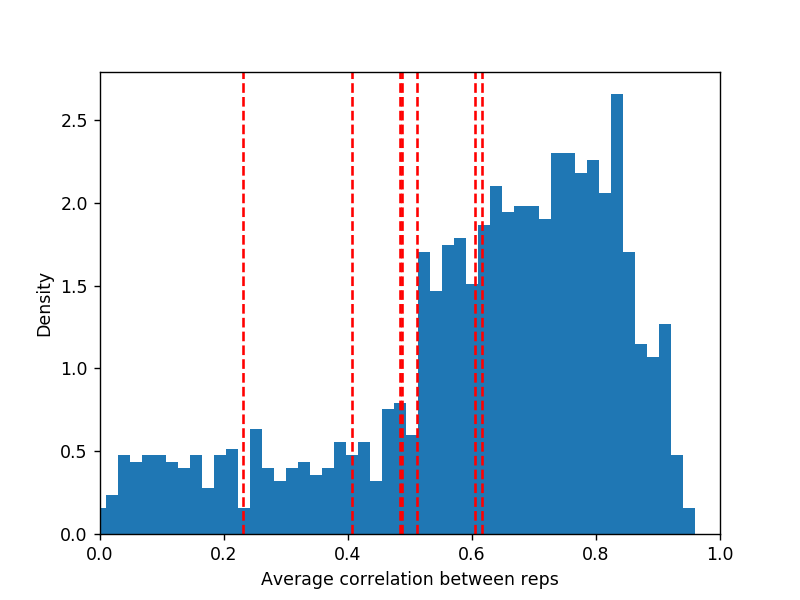

In [46]:
plt.figure()
plt.hist(reliability_arr, bins=50, density=True);
for thr in thr_list:
    plt.axvline(thr, c='red', ls='--')

plt.xlim([0,1])
plt.xlabel('Average correlation between reps')
plt.ylabel('Density');

It's also important to keep in mind the amount of responses that are available to us when calculating such reliabilities.

In [49]:
n_test_rois = 15
test_rois = np.random.choice(np.arange(traces_xr.shape[0]), n_test_rois)

rel_evol = np.full((n_test_rois, n_blocks-1), np.nan)

for block_idx, block in enumerate(np.arange(2, n_blocks)):
    rel_evol[:, block_idx] = reliability(np.swapaxes(traces_xr[test_rois, :block, :], 0, 2).values)

<IPython.core.display.Javascript object>


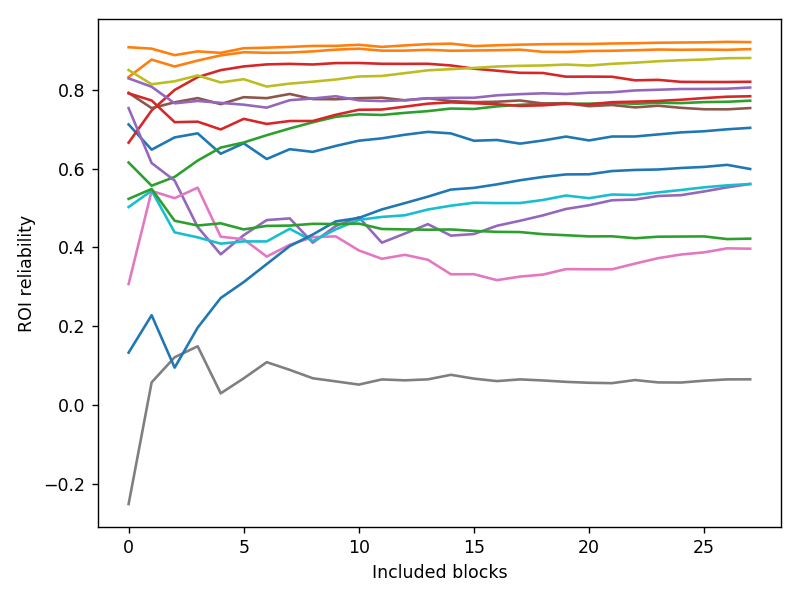

In [50]:
plt.figure()
    
for roi in range(n_test_rois):
    plt.plot(rel_evol[roi, :])
    
plt.xlabel('Included blocks')
plt.ylabel('ROI reliability') 
plt.tight_layout();

### 3. Clustering your responses

Moving onto the clustering a straightforward method is to cluster the responses based on their PCs.

In [51]:
#Calculate mean response per trial
roi_meanresps = np.nanmean(filtered_traces_xr, 1)
 
#Normalize to mean response before stimulus
for roi in range(roi_meanresps.shape[0]):
    roi_meanresps[roi, :] = roi_meanresps[roi, :] - np.nanmean(roi_meanresps[roi, :int(5/dt)] )  #5s based on our stimulus

First, it would be good to determine how many PCs should we use to describe our responses.

In [52]:
from sklearn.decomposition import PCA

In [53]:
#Perform PCA
pca = PCA(n_components=25) #Start by looking at the firts 25 PCs.
pca.fit(roi_meanresps)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


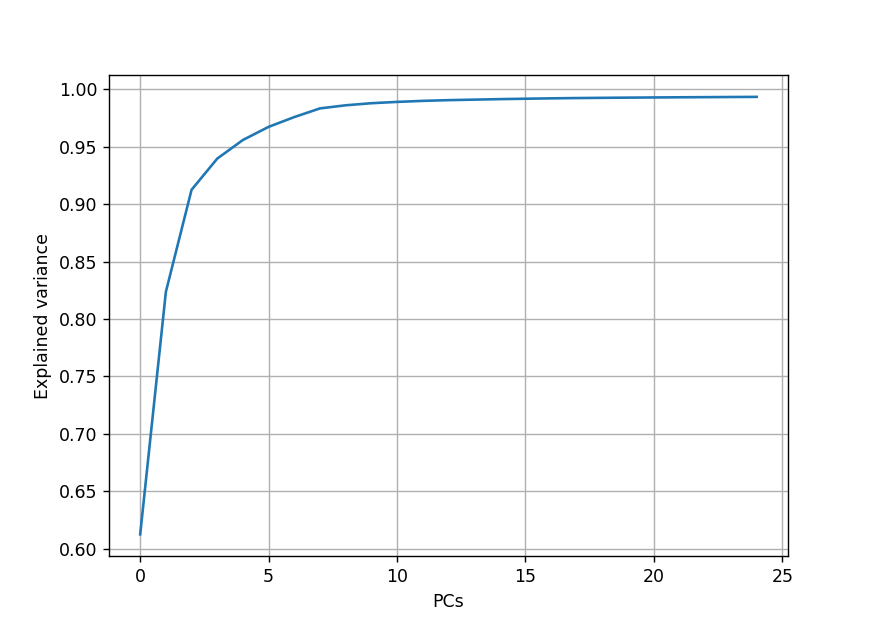

In [54]:
#Plot the cumulative explained variance by the main PCs.
x=np.arange(0,25,1)
expl_var=np.cumsum(pca.explained_variance_ratio_) #This attribute calculates the explained variance by each PC.

plt.figure(figsize=(7, 5))
plt.plot(x, expl_var)
plt.xlabel('PCs')
plt.ylabel('Explained variance')
plt.grid()

We will next use the PCs of each response to cluster them using a KMeans method. To do so, we first must decide into how many clusters we want to separate our ROIs. A simple heuristic way to define that number, is to make an **elbow plot**:

In [55]:
from sklearn.cluster import KMeans

In [56]:
#Define number of principal components based on the explained variance per PC above
n_components = 10

pca=PCA(n_components=n_components)
roi_meanresps_pca=pca.fit_transform(roi_meanresps)

In [ ]:
#Make elbow plot to choose optimal size of clusters
distorsions = []

for k in range(1, 25):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(roi_meanresps_pca) #Computes the clustering
    distorsions.append(kmeans.inertia_) #Appends the inertia attirbute of the fit: Sum of squared distances of samples to their closest cluster center.

plt.figure(figsize=(10, 5))
plt.plot(range(1,25), distorsions)

plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.grid(True)

And we cluster:

In [57]:
#Select number of clusters and clusterize
n_clusters = 5

kmeans_traces_pca = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(roi_meanresps_pca)

In [58]:
#Defining a color palette because plots should be pretty
clust_colors =["#9bcc40",
"#ce5bd9",
"#61cd75",
"#e55391",
"#d0a839",
"#8c7fe3",
"#e3633f"]

(Create your own color palettes in [iWantHue](http://medialab.github.io/iwanthue/))

In [59]:
import matplotlib.gridspec as gridspec
import seaborn as sns

<IPython.core.display.Javascript object>


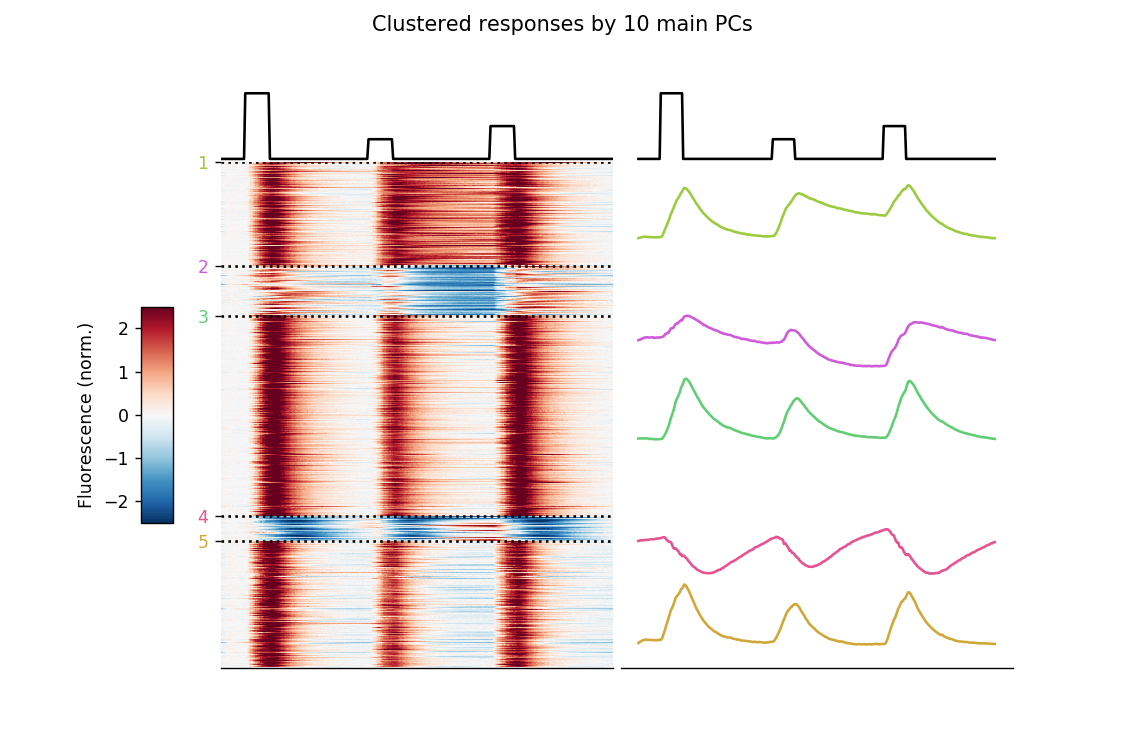

/home/otprat/anaconda3/envs/rplab/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Use the colorbar set_ticks() method instead.
/home/otprat/anaconda3/envs/rplab/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Use the colorbar set_ticks() method instead.


In [60]:
#Plot
cluster_fig = plt.figure(figsize=(9,6))

gs = gridspec.GridSpec(8,22)
gs.update(wspace=0.25, hspace=0)
ax1 = plt.subplot(gs[:1, 2:12])
ax2 = plt.subplot(gs[:1, 12:])
ax3 = plt.subplot(gs[1:, 2:12])
ax4 = plt.subplot(gs[1:, 12:], sharex=ax2)
ax5 = plt.subplot(gs[3:6, 0:1])

ax1.plot(stim_arr[0, :], stim_arr[1, :], c='black')
ax1.set_xlim(np.min(stim_arr[0, :]),np.max(stim_arr[0, :]))
ax1.axis('off')

ax2.plot(stim_arr[0, :], stim_arr[1, :], c='black')
ax2.axis('off')

heatmap = ax3.imshow(roi_meanresps[np.argsort(kmeans_traces_pca),:], aspect='auto', cmap='RdBu_r', vmin=-2.5, vmax=2.5)
unique, counts = np.unique(kmeans_traces_pca, return_counts=True)
yticks=[]
tick = 0

for cluster, roi_num in zip(unique, counts):
    yticks.append(tick)
    tick += counts[cluster]
    
ax3.set_xticks([])
ax3.set_yticks(yticks)
ax3.set_yticklabels(unique+1)
for tick in yticks:
    ax3.axhline(tick, ls=':', color='black')
ax3.set_ylim([roi_meanresps.shape[0], 0])
    
for tick, col in zip(ax3.yaxis.get_major_ticks(), clust_colors):
    tick.label1.set_color(col)

cluster, cells = np.unique(kmeans_traces_pca, return_counts=True)
cluster_roi_count = dict(zip(cluster, cells))    

for cluster, color in zip(np.unique(kmeans_traces_pca), clust_colors):
    ax4.plot(stim_arr[0, :], (roi_meanresps[kmeans_traces_pca==cluster,:].mean(0))-cluster*5, c=color, label=cluster)
ax4.set_xticks([])
ax4.set_yticks([])

sns.despine(left=True)
cluster_fig.suptitle('Clustered responses by {} main PCs'.format(n_components))

plt.colorbar(heatmap, cax=ax5)
ax5.set_yticks([])
ax5.set_xticks([])
ax5.set_ylabel('Fluorescence (norm.)')
ax5.yaxis.set_label_position('left')
ax5.yaxis.tick_left()

Hierarchical clustering

In [61]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [62]:
#Pick a random subset of ROis
rand_rois = np.random.choice(roi_meanresps_pca.shape[0], size=50, replace=False)

#Clustering
linked = linkage(roi_meanresps_pca[rand_rois, :])

<IPython.core.display.Javascript object>


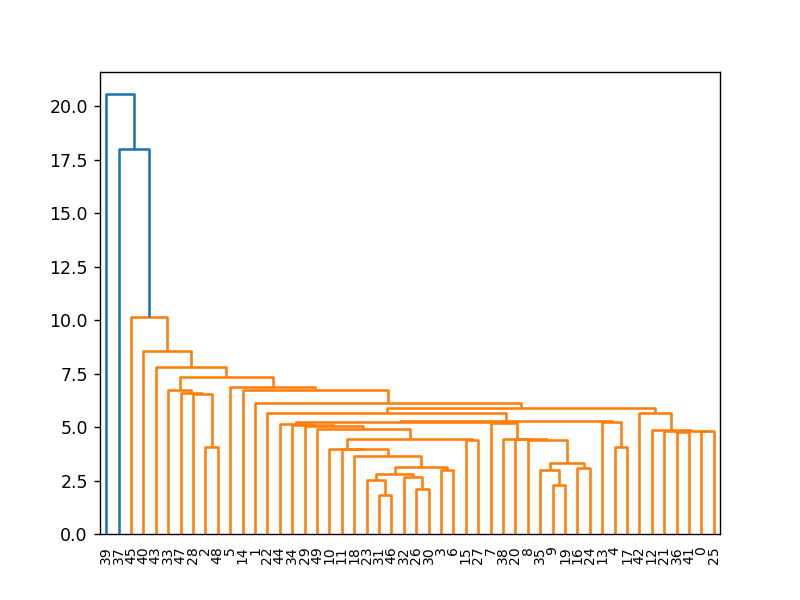

In [63]:
#Plot
plt.figure()
dendrogram(linked);

Interactive plots

In [ ]:
from ipywidgets import interact
from ipywidgets.widgets import IntSlider, Dropdown

In [64]:
def plot_cluster_rois(cluster, roi):
    
    roi_idx = np.nonzero(kmeans_traces_pca==cluster)[0][roi]
        
    ex_roi_fig = plt.figure()
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.25, hspace=0)
    ax1 = plt.subplot(gs[:2, :])
    ax2 = plt.subplot(gs[2:, :], sharex=ax1)

    ax1.plot(stim_arr[0,:], stim_arr[1, :], c='black')
    ax1.set_xlim(np.min(stim_arr[0,:]),np.max(stim_arr[0,:]))
    ax1.axis('off')

    for block in range(n_blocks):
        ax2.plot(filtered_traces_xr.coords['t'], filtered_traces_xr[roi_idx, block, :], c='gray', alpha=.1)

    ax2.plot(filtered_traces_xr.coords['t'], np.nanmean(filtered_traces_xr[roi_idx, :, :], 0), c=clust_colors[cluster])

    ax2.set_xlabel('Time [s.]')
    ax2.set_ylabel('dF/F')
    
    ax1.set_title('Cluster {}, ROI {}'.format(cluster+1, roi))
    

In [65]:
cluster_roi_resps = interact(plot_cluster_rois,
                             cluster=Dropdown(options=np.unique(kmeans_traces_pca), 
                                              description='Cluster'),
                             roi=IntSlider(min=0, 
                                           max=np.nonzero(kmeans_traces_pca==cluster)[0].shape[0]-1, 
                                           step=1, 
                                           continuous_update=True))
display(cluster_roi_resps)

NameError: name 'interact' is not defined